### The first week of active prep - experiments with classifiers using sklearn lib.
#### ( first iteration -> not the highest quality of EDA, tuning etc )

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

In [2]:
data = pd.read_csv("heart.csv")

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
from sklearn.model_selection import train_test_split as tts

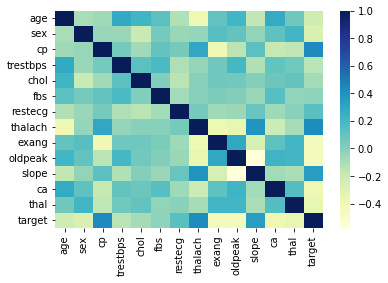

In [5]:
# firstly, I'd build the correlation matrix
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu")
# as can be seen, cp, slope and thalach seem to have the highest correlation among other. 
# thus, except for random forest, I would use them for LogReg, linear svm
# for random forest and kernel svm, I'd use all of the features.

In [6]:
X = data[['cp','thalach','slope','age','restecg','chol']]
y = data['target']

X_train, X_test, y_train, y_test = tts(X,y,test_size=0.2, random_state = 228)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C = 55, solver ='liblinear')
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
print('The first iteration with logistic regression accuracy: ',
      accuracy_score(y_pred, y_test))

The first iteration with logistic regression accuracy:  0.8032786885245902


In [8]:
# now let's standardise the data:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

In [9]:
lr = LogisticRegression(C=1, solver ='liblinear')
lr.fit(X_train_std,y_train)
y_pred = lr.predict(X_test_std)
print('The second iteration with logistic regression accuracy: ',
      accuracy_score(y_pred, y_test))
# However, this does not help here somehow *_* now we'll use the RandomForest classifier

The second iteration with logistic regression accuracy:  0.7868852459016393


In [10]:
# I'll use all data here
new_X = data.drop('target',axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = tts(new_X,y,test_size=0.2, random_state = 228)



In [15]:
from sklearn.ensemble import RandomForestClassifier

wood = RandomForestClassifier(n_estimators = 500, random_state = 228, n_jobs = 2)
wood.fit(new_X_train, new_y_train)


RandomForestClassifier(n_estimators=500, n_jobs=2, random_state=228)

In [16]:
y_pred1 = wood.predict(new_X_test)
print('The first iteration with Random Forest accuracy: ',
      accuracy_score(y_pred1, new_y_test))
#Here, we can see that the accuracy is ± 5% higher than in LR case

The first iteration with Random Forest accuracy:  0.8524590163934426


In [17]:
X_train_std1 = std.fit_transform(new_X_train)
X_test_std1 = std.fit_transform(new_X_test)

In [18]:
wood.fit(X_train_std1, new_y_train)
y_pred1 = wood.predict(X_test_std1)
print('The first iteration with Random Forest accuracy: ',
      accuracy_score(y_pred1, new_y_test))
#Scaling did not do much here tho...

The first iteration with Random Forest accuracy:  0.8524590163934426


### The results shown by Random forest are superior to LR, for now. I'll probably return to this dataset in the next weeks with better EDA and other methods used.


### Now, let's use the L1-L2 penalty as well as RobustScaler and Random Forest feture selection

In [22]:
# Firstly, let's output the most significant features according to the RF
from matplotlib import pyplot as plt

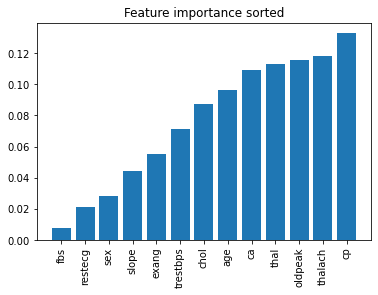

In [31]:
wood.feature_importances_
fancy_importance = {new_X.columns[i]:wood.feature_importances_[i] for i in range(13)}
fancy_importance = dict(sorted(fancy_importance.items(), key=lambda item: item[1]))
plt.bar(range(13),fancy_importance.values())
plt.xticks(range(13), fancy_importance.keys(), rotation = 90)
plt.title("Feature importance sorted")
plt.show()

In [39]:
#Now, as we can see, some of the feature lack importance -> 
#it's logical to try and eliminate them
X_elim = pd.DataFrame()
for key in fancy_importance:
    if(fancy_importance[key] > 0.08):
        X_elim[key] = new_X[key]

In [42]:
X_elim.head() # Now we are left with ( hopefully ) the most meaningful features.
new_X_train, new_X_test, new_y_train, new_y_test = tts(X_elim,y,test_size=0.2, random_state = 228, stratify=y)

In [48]:
wood = RandomForestClassifier(n_estimators = 50, random_state = 228, n_jobs = 2)
wood.fit(new_X_train, new_y_train)
y_pred1 = wood.predict(new_X_test)
print('The first iteration with Random Forest accuracy after elimination: ',
      accuracy_score(y_pred1, new_y_test))

The first iteration with Random Forest accuracy after elimination:  0.7868852459016393


In [57]:
lr2 = LogisticRegression(C=0.1,penalty ='l2', solver = 'liblinear')
lr2.fit(new_X_train, new_y_train)
y_pred2 = lr2.predict(new_X_test)
print('The first iteration with LogRegr accuracy after elimination: ',
      accuracy_score(y_pred2, new_y_test))

The first iteration with LogRegr accuracy after elimination:  0.7213114754098361


### The results are not very promising...
### Need to learn the EDA from Kaggle imo
### However, let's use the RobustScaler and check if it works with the OG data. Also, after that I'd like to use L1-2 penalties on the og data

In [59]:
from sklearn.preprocessing import RobustScaler

In [72]:
#KOLHOZ SORRY
categories = [False,True,True,False,False,True,True,False,True,False,True,True,]
to_scale = [False,False,False,True,True,False,False,True,False,True,False,False,False]
for i in range(13):
    if(to_scale[i] ==True):
        scaler = RobustScaler()
        new_X[new_X.columns[i]] =scaler.fit_transform(np.array(new_X[new_X.columns[i]]).reshape(-1,1))

In [66]:
new_X.columns

'age'

In [73]:
new_X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,0.75,-0.110236,1,0,-0.092308,0,0.9375,0,0,1
1,37,1,2,0.00,0.157480,0,1,1.046154,0,1.6875,0,0,2
2,41,0,1,0.00,-0.566929,0,0,0.584615,0,0.3750,2,0,2
3,56,1,1,-0.50,-0.062992,0,1,0.769231,0,0.0000,2,0,2
4,57,0,0,-0.50,1.795276,0,1,0.307692,1,-0.1250,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,0.50,0.015748,0,1,-0.923077,1,-0.3750,1,0,3
299,45,1,3,-1.00,0.377953,0,1,-0.646154,0,0.2500,1,0,3
300,68,1,0,0.70,-0.740157,1,1,-0.369231,0,1.6250,1,2,3
301,57,1,0,0.00,-1.716535,0,1,-1.169231,1,0.2500,1,1,3
